PDFstream v0.1.3

In [ ]:
from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

import pdfstream.cli as cli
from pdfstream.utils.jupyter import FigExporter
import pdfstream.visualization as vis
import pdfstream.parsers as parsers


# matplotlib settings
style_file = Path("/Users/sst/PycharmProjects/mpl-stylesheets/bg_style")
if style_file.is_file():
    plt.style.use(str(style_file))
del style_file

def readDF():
    """read metadata of analysis."""
    return pd.read_csv("data_info.csv", index_col=0)

DF = readDF()

CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.set_option('float_format', '{:.3f}'.format)

client = MongoClient()
db = client.tio2b
fits = db.fits
data = db.data

In [2]:
from pdfstream.utils.jupyter import savefig_factory

save = FigExporter("/Users/sst/project/papers/19st_tio2b/paper/figures")
save.update(dpi=600)

In [3]:
def get_rw_df(df: pd.DataFrame, col: str) -> list:
    """Get the Rw value from a record of results files."""
    return [get_rw(csv) for csv in df[col]]

def get_rw(csv_file: str) -> float:
    """Get Rw from the csv_file"""
    return pd.read_csv(csv_file, index_col=0).iloc[0, 0]

Get sample JBNP33L as an example

In [4]:
example = data.find_one({"meta_data.sample":"JBNP33L"})

Plot the PDF

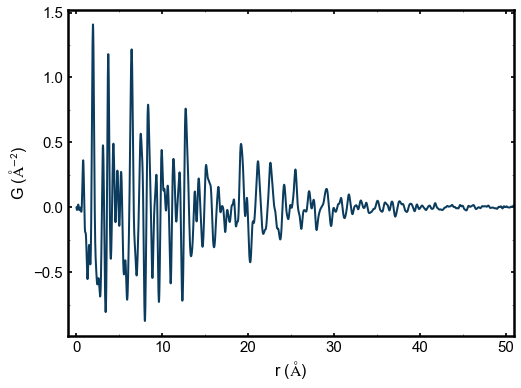

In [5]:
plt.figure(figsize=(8, 6))
ax = cli.visualize(example["gr_file"], show_fig=False)
ax.set_xbound(0, 50)
ax.set_xlim(-1, 51)
#save("example_gr.pdf")
plt.show()
del ax

The results from the PDFitc

In [6]:
pdfitc_results = pd.read_csv('info/pdfitc_rmax_15.csv', index_col=0)
pdfitc_results = pdfitc_results[['rw', 'formula', 'space_group', 'db', 'db_id']]
pdfitc_results = pdfitc_results.iloc[:5]
print(pdfitc_results.to_latex())

\begin{tabular}{lrllll}
\toprule
{} &    rw & formula & space\_group &   db &       db\_id \\
\midrule
0 & 0.362 &    TiO2 &        C2/m &  MPD &   mp-554278 \\
1 & 0.798 &    TiO2 &        C2/m &  COD &     1528778 \\
2 & 0.846 &    TiO2 &          P1 &  MPD &  mp-1245308 \\
3 & 0.873 &    TiO2 &    I4\_1/amd &  COD &     7206075 \\
4 & 0.874 &    TiO2 &    I4\_1/amd &  COD &     1526931 \\
\bottomrule
\end{tabular}



In [7]:
def format_rw(sr: pd.Series, csv_col: str) -> str:
    """Format the text for Rw."""
    rw = get_rw(sr[csv_col])
    return r"$R_w$ = {:.2f}".format(rw)


def format_text(csv_col: str, sr: pd.Series = example):
    """Generate the text for the plot. Each contains an equation of the model and a Rw value."""
    if csv_col == "csv1":
        eq = r"$G_{np}(r) = f_{spherical}(r) G_{bronze}(r)$"
    elif csv_col == "csv_twop":
        eq = r"$G_{np}(r) = f_{lognormal} G_{bronze}(r)$"
    elif csv_col == "csv4":
        eq = r"$G_{np}(r) = f_{lognormal} G_{bronze}(r)$" +\
        "\n\t " + r"$+ f_3(r)G_{anatase}(r)$"
    elif csv_col == "csv_two_phase_sine_wave":
        eq = r"$G_{np}(r) = f_{lognormal} G_{bronze}(r)$" +\
        "\n\t " + r"$+ f_3(r)G_{anatase}(r)$"+\
        "\n\t " + r"$+ \lambda \exp({\frac{- r^2}{2 \sigma^2}}) \sin(kr + \phi)$"
    else:
        raise ValueError("No equation for csv_col {}. Allowed: csv1, csv_twop, csv4, csv_two_phase_sine_wave").format(csv_col)
    return eq + "\n" + format_rw(sr, csv_col)


def label(fit: dict):
    """Generate the text for the plot. Each contains an equation of the model and a Rw value."""
    return fit["eq"] + "\n" + r"$R_w$ = {:.3f}".format(fit["rw"])

List all the fits.

Compare the different characteristic functions

In [8]:
def get_data(doc):
    return parsers.dict_to_array(doc, ('conresults', 0))

In [9]:
import xarray as xr

In [10]:
from bson.objectid import ObjectId
import pdfstream.visualization.tools as vt


fit0 = fits.find_one({"_id": ObjectId("5f564af1438ad082e6d6cce4")})
fit0["eq"] = r"$G(r) = f^{spherical}_{bronze}(r) G_{bronze}(r)$"
data0 = get_data(fit0)
label0 = label(fit0)

fit1 = fits.find_one({"_id": ObjectId("5f555f65438ad082e6d6ccdf")})
fit1["eq"] = r"$G(r) = f^{lognormal}_{bronze}(r) G_{bronze}(r)$"
data1 = get_data(fit1)
label1 = label(fit1)

fit2 = fits.find_one({"_id": ObjectId("5f5563bf438ad082e6d6cce0")})
fit2["eq"] = r"$G(r) = f^{lognormal}_{bronze}(r) G_{bronze}(r)$""\n\t""$ + f^{spherical}_{anatase}(r) G_{anatase}(r)$"
data2 = get_data(fit2)
label2 = label(fit2)

fit3 = fits.find_one({"_id": ObjectId("5f563cb3438ad082e6d6cce2")})
fit3["eq"] = r"$G(r) = f^{lognormal}_{bronze}(r) G_{bronze}(r)$""\n\t""$ + f^{spherical}_{anatase}(r) G_{anatase}(r)+ f_{ligand}(r)$"
data3 = get_data(fit3)
label3 = label(fit3)

fit4 = fits.find_one({"_id": ObjectId("5f5646e8438ad082e6d6cce3")})
fit4["eq"] = r"$G(r) = f^{core}_{bronze}(r) G_{bronze}(r)$""\n\t""$ + f^{shell}_{anatase}(r) G_{anatase}(r)+ f_{ligand}(r)$"
data4 = get_data(fit4)
label4 = label(fit4)

In [21]:
from pdfstream.io import load_array

gr = load_array(example["gr_file"])

In [11]:
raw_data = np.stack([data0, data1, data2, data3, data4])
labels = np.array([label0, label1, label2, label3, label4], dtype=str)

In [27]:
import xarray as xr


ds = xr.Dataset(
    {
        "raw": (["type", "index0"], gr),
        "data": (["model", "result", "index1"], raw_data),
        "label": (["model"], labels)
    },
    coords={
        "type": ["r", "g"],
        "model": ["a", "b", "c", "d", "e"],
        "result": ["r", "g", "gcalc"]
    }
)
# ds.to_netcdf("figure_data/fit_results.nc")

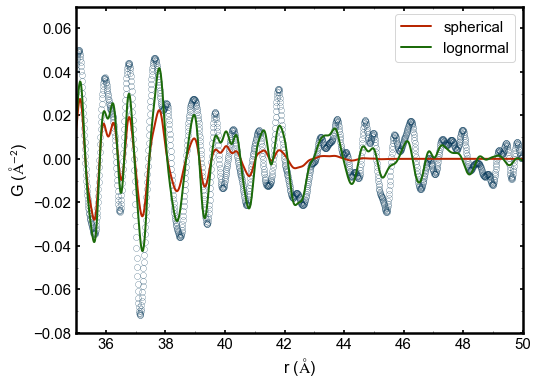

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(*data0[[0, 2]], "o", mfc='none')
ax.plot(*data0[[0, 1]], label="spherical")
ax.plot(*data1[[0, 1]], label="lognormal")
ax.legend()
ax.set_xbound(35, 50)
ax.set_ybound(-0.08, 0.07)
vt.set_minor_tick(ax)
vt.auto_label(ax, "gr");

A figure of four fits

In [21]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(8 * 2, 6 * 3))
grids = GridSpec(3, 2)
axes = [fig.add_subplot(_) for _ in grids]
axes.pop().remove()
plt.close()
del grids

The fitting of the major phase

In [22]:
ax = vis.visualize(
    data0, mode="fit",
    text=label(fit0),
    text_xy = (.4, .75),
    ax=axes[0],
    color=CYCLE[0],
    label="gr"
)
ax.set_title("(a)", loc="left")
ax.set_xlim(-1, 51)
ax.set_ylim(-1.4, 1.65)
plt.close()

use the linear combination of spherical characteristic function

In [23]:
ax = vis.visualize(
    data1, mode="fit",
    text=label(fit1),
    text_xy = (.4, .75),
    ax=axes[1],
    color=CYCLE[1],
    label="gr"
)
ax.set_title("(b)", loc="left")
ax.set_xlim(-1, 51)
ax.set_ylim(-1.4, 1.65)
plt.close()

add another phase Anatase

In [24]:
ax = vis.visualize(
    data2, mode="fit",
    text=label(fit2),
    text_xy = (.4, .75),
    ax=axes[2],
    color=CYCLE[2],
    label="gr"
)
ax.set_title("(c)", loc="left")
ax.set_xlim(-1, 51)
ax.set_ylim(-1.4, 1.65)
plt.close()

add ligand PDF

In [25]:
ax = vis.visualize(
    data3, mode="fit",
    text=label(fit3),
    text_xy = (.4, .75),
    ax=axes[3],
    color=CYCLE[3],
    label="gr"
)
ax.set_title("(d)", loc="left")
ax.set_xlim(-1, 51)
ax.set_ylim(-1.4, 1.65)
plt.close()

core shell fitting

In [26]:
ax = vis.visualize(
    \done, mode="fit",
    text=label(fit4),
    text_xy = (.4, .75),
    ax=axes[4],
    color=CYCLE[4],
    label="gr"
)
ax.set_title("(e)", loc="left")
ax.set_xlim(-1, 51)
ax.set_ylim(-1.4, 1.65)
plt.close()

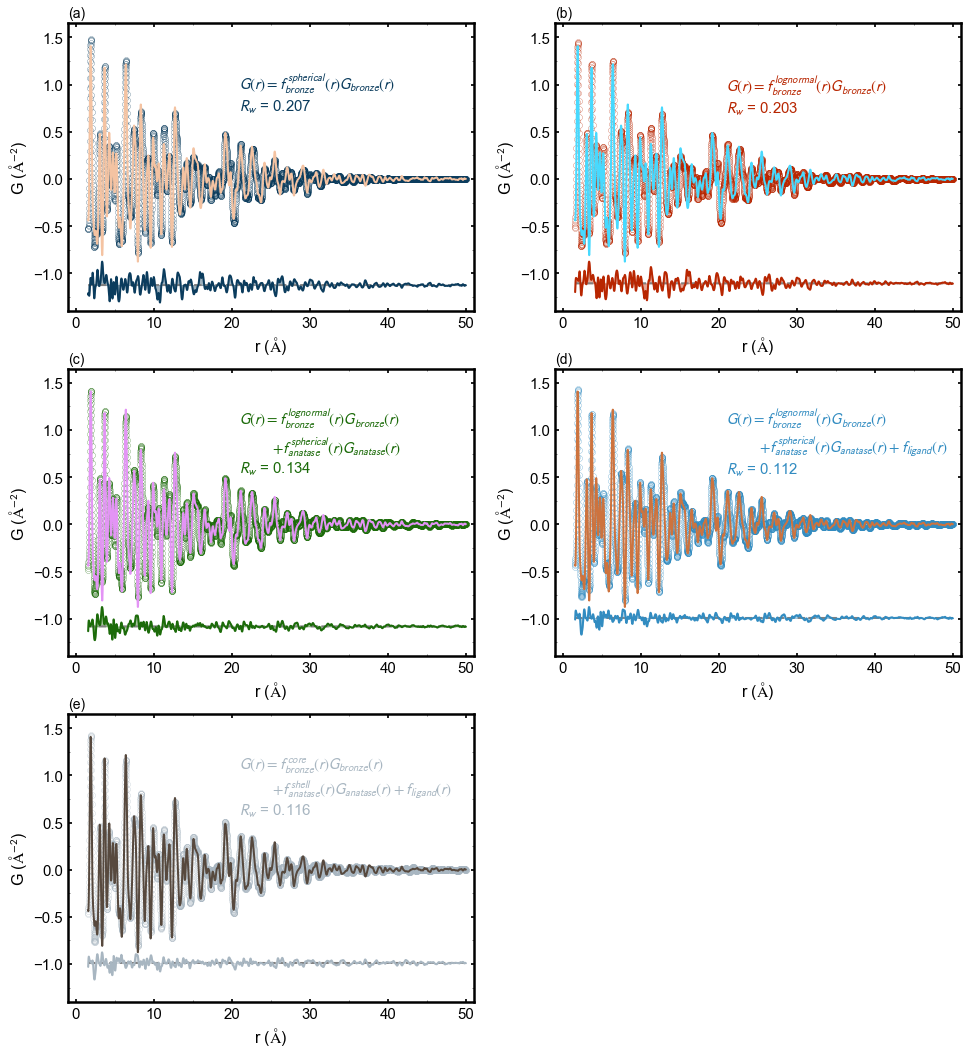

In [27]:
fig

save the figure

Components of the fitting

In [39]:
comp0 = np.loadtxt("info/JBNP33L_core_shell_grs.gr").T
comp1 = np.loadtxt("info/JBNP33L_grs.gr").T

In [44]:
fig = plt.figure(figsize=(8, 6 * 2))
grids = GridSpec(2, 1, hspace=0)
axes = list(map(fig.add_subplot, grids))
plt.close()

In [45]:
ax = vis.waterfall(
    [comp0[[0, 1]], comp0[[0, 2]], comp0[[0, 3]]],
    normal=False,
    gap=0.2,
    label="gr",
    ax=axes[0]
);
lines = ax.get_lines()
ax.annotate("(a)", (0.9, .9), xycoords='axes fraction')
ax.annotate("bronze (lognormal)", (35, 0.5), color=lines[0].get_color())
ax.annotate("anatase (spherical)", (35, -1.0), color=lines[1].get_color())
ax.annotate("ligand", (35, -1.5), color=lines[2].get_color())
ax.set_xlabel([])
ax.set_ylim(-1.75, 1.65)
plt.close()

In [46]:
ax = vis.waterfall(
    [comp1[[0, 1]], comp1[[0, 2]], comp1[[0, 3]]],
    normal=False,
    gap=0.2,
    label="gr",
    ax=axes[1]
);
lines = ax.get_lines()
ax.annotate("(b)", (0.9, .9), xycoords='axes fraction')
ax.annotate("bronze (core)", (35, 0.5), color=lines[0].get_color())
ax.annotate("anatase (shell)", (35, -1.0), color=lines[1].get_color())
ax.annotate("ligand", (35, -1.5), color=lines[2].get_color())
ax.set_ylim(-1.75, 1.65)
plt.close()

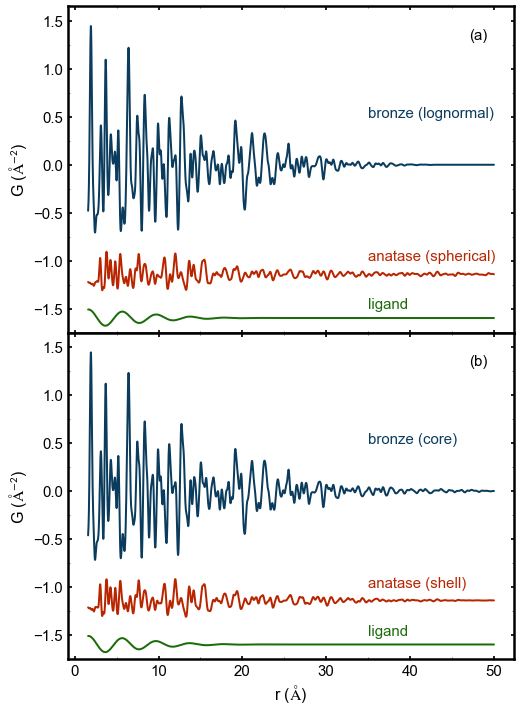

In [47]:
fig

save the figure